In [56]:
import os
import sys
from collections import defaultdict
from functools import reduce, partial
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from scipy import spatial
from scipy.spatial.distance import pdist, cdist, squareform
import tqdm

from pymutspec.annotation import mutations_summary, calculate_mutspec, lbl_id2lbl, lbl2lbl_id
from pymutspec.constants import possible_sbs192, possible_sbs12
from pymutspec.draw import plot_mutspec192, plot_mutspec12
from pymutspec.draw.sbs_orders import ordered_sbs192_kp

## Load data

### Check invar sites intersection

In [2]:
r_nd1 = pd.concat([
    pd.read_csv("../data/exposure/mammals_nd1/states/gtr.rate", comment="#", sep="\t"),
    pd.read_csv("../data/exposure/mammals_nd1/states/strsym.rate", comment="#", sep="\t"),
    pd.read_csv("../data/exposure/mammals_nd1/states/unrest.rate", comment="#", sep="\t"),
], ignore_index=True).groupby("Site").Cat.value_counts().unstack().fillna(0).astype(np.int8)

r_cytb = pd.concat([
    pd.read_csv("../data/exposure/mammals_cytb/states/gtr.rate", comment="#", sep="\t"),
    pd.read_csv("../data/exposure/mammals_cytb/states/strsym.rate", comment="#", sep="\t"),
    pd.read_csv("../data/exposure/mammals_cytb/states/unrest.rate", comment="#", sep="\t"),
], ignore_index=True).groupby("Site").Cat.value_counts().unstack().fillna(0).astype(np.int8)

#### Different model assign different cats to same sites

In [3]:
r_nd1[r_nd1.max(axis=1) < 2]

Cat,0,1,2,3,4,5,6
Site,,,,,,,
48,0,0,0,0,1,1,1
222,0,0,0,0,1,1,1
229,0,0,0,1,1,1,0
234,0,0,0,0,1,1,1
246,0,0,0,0,1,1,1
265,0,0,0,1,1,1,0
369,0,0,0,0,1,1,1
396,0,0,0,0,1,1,1
405,0,0,0,0,1,1,1


In [9]:
r_cytb[r_cytb.max(axis=1) < 2]

Cat,0,1,2,3,4,5,6
Site,,,,,,,
72,0,0,0,0,1,1,1
240,0,0,0,0,1,1,1
426,0,0,0,0,1,1,1
477,0,0,0,0,1,1,1
712,0,0,0,1,1,1,0
1096,0,0,1,1,1,0,0


#### But invariable sites are same for each model

In [7]:
r_nd1[r_nd1[0] > 0][0].value_counts()

3    181
Name: 0, dtype: int64

In [8]:
r_cytb[r_cytb[0] > 0][0].value_counts()

3    267
Name: 0, dtype: int64

### Load rates and cats

In [2]:
dtypes_rate = {"Site": np.int16, "Cat": np.int8}

rate_nd1 = pd.read_csv("../data/exposure/mammals_nd1/states/gtr.rate", comment="#", sep="\t", dtype=dtypes_rate)
rate_cytb = pd.read_csv("../data/exposure/mammals_cytb/states/gtr.rate", comment="#", sep="\t", dtype=dtypes_rate)
rate_cytb.head()

,Site,Rate,Cat,C_Rate
0,1,0.00187,0,0.00000
1,2,0.00003,0,0.00000
2,3,0.01569,1,0.01569
3,4,0.19571,2,0.12291
4,5,0.37341,3,0.37341


### Load observed mutations

In [3]:
dtypes = dict(
    Mut=str,
    Label=np.int8, 
    PosInGene=np.int16,
    ProbaMut=np.float32, 
    ProbaFull=np.float32,
    RefNode=str,
    AltNode=str,
)
usecols = list(dtypes.keys())
usecols_simple = [x for x in usecols if not x.startswith("Proba")]

PATH_TO_DATA = "../data/exposure/mammals_nd1/"
mut_nd1 = pd.concat([
    # pd.read_csv(os.path.join(PATH_TO_DATA, "RY6.8a_proba/mutations.tsv"), dtype=dtypes, usecols=usecols, sep='\t').assign(Aproach="RY6.8a"),
    # pd.read_csv(os.path.join(PATH_TO_DATA, "unrest_simple/mutations.tsv"), dtype=dtypes, usecols=usecols_simple, sep='\t').assign(Aproach="unrest_simple"),
    # pd.read_csv(os.path.join(PATH_TO_DATA, "unrest_proba/mutations.tsv"), dtype=dtypes, usecols=usecols, sep='\t').assign(Aproach="unrest_proba"),
    
    pd.read_csv(os.path.join(PATH_TO_DATA, "gtr_simple/mutations.tsv"),    dtype=dtypes, usecols=usecols_simple, sep='\t').assign(Aproach="gtr_simple"),
    pd.read_csv(os.path.join(PATH_TO_DATA, "strsym_simple/mutations.tsv"), dtype=dtypes, usecols=usecols_simple, sep='\t').assign(Aproach="strsym_simple"),
    pd.read_csv(os.path.join(PATH_TO_DATA, "RY8.8_simple/mutations.tsv"),  dtype=dtypes, usecols=usecols_simple, sep='\t').assign(Aproach="RY8.8_simple"),
    pd.read_csv(os.path.join(PATH_TO_DATA, "RY10.12_simple/mutations.tsv"),dtype=dtypes, usecols=usecols_simple, sep='\t').assign(Aproach="RY10.12_simple"),

    pd.read_csv(os.path.join(PATH_TO_DATA, "gtr_proba/mutations.tsv"),     dtype=dtypes, usecols=usecols, sep='\t').assign(Aproach="gtr"),
    pd.read_csv(os.path.join(PATH_TO_DATA, "strsym_proba/mutations.tsv"),  dtype=dtypes, usecols=usecols, sep='\t').assign(Aproach="strsym"),
    pd.read_csv(os.path.join(PATH_TO_DATA, "RY8.8_proba/mutations.tsv"),   dtype=dtypes, usecols=usecols, sep='\t').assign(Aproach="RY8.8"),
    pd.read_csv(os.path.join(PATH_TO_DATA, "RY10.12_proba/mutations.tsv"), dtype=dtypes, usecols=usecols, sep='\t').assign(Aproach="RY10.12"),
    pd.read_csv(os.path.join(PATH_TO_DATA, "pastml/mutations.tsv"), dtype=dtypes, usecols=usecols, sep='\t').assign(Aproach="pastml"),
], ignore_index=True).fillna(value=dict(ProbaMut=1., ProbaRef=1., ProbaFull=1.))

mut_nd1["MutBase"] = mut_nd1["Mut"].str.slice(2, 5).astype("category")


PATH_TO_DATA = "../data/exposure/mammals_cytb/"
mut_cytb = pd.concat([
    # pd.read_csv(os.path.join(PATH_TO_DATA, "RY6.8a_proba/mutations.tsv"), dtype=dtypes, usecols=usecols, sep='\t').assign(Aproach="RY6.8a"),
    # pd.read_csv(os.path.join(PATH_TO_DATA, "unrest_simple/mutations.tsv"), dtype=dtypes, usecols=usecols_simple, sep='\t').assign(Aproach="unrest_simple"),
    # pd.read_csv(os.path.join(PATH_TO_DATA, "unrest_proba/mutations.tsv"), dtype=dtypes, usecols=usecols, sep='\t').assign(Aproach="unrest_proba"),
    
    pd.read_csv(os.path.join(PATH_TO_DATA, "gtr_simple/mutations.tsv"),    dtype=dtypes, usecols=usecols_simple, sep='\t').assign(Aproach="gtr_simple"),
    pd.read_csv(os.path.join(PATH_TO_DATA, "strsym_simple/mutations.tsv"), dtype=dtypes, usecols=usecols_simple, sep='\t').assign(Aproach="strsym_simple"),
    pd.read_csv(os.path.join(PATH_TO_DATA, "RY8.8_simple/mutations.tsv"),  dtype=dtypes, usecols=usecols_simple, sep='\t').assign(Aproach="RY8.8_simple"),
    pd.read_csv(os.path.join(PATH_TO_DATA, "RY10.12_simple/mutations.tsv"),dtype=dtypes, usecols=usecols_simple, sep='\t').assign(Aproach="RY10.12_simple"),

    pd.read_csv(os.path.join(PATH_TO_DATA, "gtr_proba/mutations.tsv"),     dtype=dtypes, usecols=usecols, sep='\t').assign(Aproach="gtr"),
    pd.read_csv(os.path.join(PATH_TO_DATA, "strsym_proba/mutations.tsv"),  dtype=dtypes, usecols=usecols, sep='\t').assign(Aproach="strsym"),
    pd.read_csv(os.path.join(PATH_TO_DATA, "RY8.8_proba/mutations.tsv"),   dtype=dtypes, usecols=usecols, sep='\t').assign(Aproach="RY8.8"),
    pd.read_csv(os.path.join(PATH_TO_DATA, "RY10.12_proba/mutations.tsv"), dtype=dtypes, usecols=usecols, sep='\t').assign(Aproach="RY10.12"),
    pd.read_csv(os.path.join(PATH_TO_DATA, "pastml/mutations.tsv"), dtype=dtypes, usecols=usecols, sep='\t').assign(Aproach="pastml"),
], ignore_index=True).fillna(value=dict(ProbaMut=1., ProbaRef=1., ProbaFull=1.))

mut_cytb["MutBase"] = mut_cytb["Mut"].str.slice(2, 5).astype("category")

mut_nd1 = mut_nd1[mut_nd1.RefNode != "ROOT"]
mut_cytb = mut_cytb[mut_cytb.RefNode != "ROOT"]

mut_nd1 = mut_nd1.merge(rate_nd1[["Site", "Cat"]].rename(columns={"Site": "PosInGene"}), on="PosInGene")
mut_cytb = mut_cytb.merge(rate_cytb[["Site", "Cat"]].rename(columns={"Site": "PosInGene"}), on="PosInGene")

In [4]:
mut_cytb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3674004 entries, 0 to 3674003
Data columns (total 10 columns):
 #   Column     Dtype   
---  ------     -----   
 0   Mut        object  
 1   Label      int8    
 2   PosInGene  int16   
 3   RefNode    object  
 4   AltNode    object  
 5   Aproach    object  
 6   ProbaMut   float32 
 7   ProbaFull  float32 
 8   MutBase    category
 9   Cat        int8    
dtypes: category(1), float32(2), int16(1), int8(2), object(4)
memory usage: 185.7+ MB


### Load expected mutations freqs

In [5]:
dtypes_exp = dict(
    Mut=str,
    Label=str, 
    Pos=np.int16,
    Proba=np.float32, 
    Node=str,
)
usecols_exp = list(dtypes_exp.keys())
usecols_exp_simple = [x for x in usecols_exp if not x.startswith("Proba")]

PATH_TO_DATA = "../data/exposure/mammals_cytb/"
exp_cytb = pd.concat([
    # pd.read_csv(os.path.join(PATH_TO_DATA, "unrest_proba/expected_mutations.tsv"), dtype=dtypes_exp, usecols=usecols_exp, sep='\t').assign(Aproach="unrest_proba"),
    # pd.read_csv(os.path.join(PATH_TO_DATA, "unrest_simple/expected_mutations.tsv"), dtype=dtypes_exp, usecols=usecols_exp_simple, sep='\t').assign(Aproach="unrest_simple"),
    # pd.read_csv(os.path.join(PATH_TO_DATA, "RY6.8a_proba/expected_mutations.tsv"), dtype=dtypes_exp, usecols=usecols_exp, sep='\t').assign(Aproach="RY6.8a"),
    
    pd.read_csv(os.path.join(PATH_TO_DATA, "gtr_simple/expected_mutations.tsv"),    dtype=dtypes_exp, usecols=usecols_exp_simple, sep='\t').assign(Aproach="gtr_simple"),
    pd.read_csv(os.path.join(PATH_TO_DATA, "strsym_simple/expected_mutations.tsv"), dtype=dtypes_exp, usecols=usecols_exp_simple, sep='\t').assign(Aproach="strsym_simple"),
    pd.read_csv(os.path.join(PATH_TO_DATA, "RY8.8_simple/expected_mutations.tsv"),  dtype=dtypes_exp, usecols=usecols_exp_simple, sep='\t').assign(Aproach="RY8.8_simple"),
    pd.read_csv(os.path.join(PATH_TO_DATA, "RY10.12_simple/expected_mutations.tsv"),dtype=dtypes_exp, usecols=usecols_exp_simple, sep='\t').assign(Aproach="RY10.12_simple"),
    
    pd.read_csv(os.path.join(PATH_TO_DATA, "gtr_proba/expected_mutations.tsv"),     dtype=dtypes_exp, usecols=usecols_exp, sep='\t').assign(Aproach="gtr"),
    pd.read_csv(os.path.join(PATH_TO_DATA, "strsym_proba/expected_mutations.tsv"),  dtype=dtypes_exp, usecols=usecols_exp, sep='\t').assign(Aproach="strsym"),
    pd.read_csv(os.path.join(PATH_TO_DATA, "RY8.8_proba/expected_mutations.tsv"),   dtype=dtypes_exp, usecols=usecols_exp, sep='\t').assign(Aproach="RY8.8"),
    pd.read_csv(os.path.join(PATH_TO_DATA, "RY10.12_proba/expected_mutations.tsv"), dtype=dtypes_exp, usecols=usecols_exp, sep='\t').assign(Aproach="RY10.12"),
    pd.read_csv(os.path.join(PATH_TO_DATA, "pastml/expected_mutations.tsv"),        dtype=dtypes_exp, usecols=usecols_exp, sep='\t').assign(Aproach="pastml"),
], ignore_index=True).fillna(value=dict(Proba=1.))


PATH_TO_DATA = "../data/exposure/mammals_nd1/"
exp_nd1 = pd.concat([
    # pd.read_csv(os.path.join(PATH_TO_DATA, "unrest_proba/expected_mutations.tsv"), dtype=dtypes_exp, usecols=usecols_exp, sep='\t').assign(Aproach="unrest_proba"),
    # pd.read_csv(os.path.join(PATH_TO_DATA, "unrest_simple/expected_mutations.tsv"), dtype=dtypes_exp, usecols=usecols_exp_simple, sep='\t').assign(Aproach="unrest_simple"),
    # pd.read_csv(os.path.join(PATH_TO_DATA, "RY6.8a_proba/expected_mutations.tsv"), dtype=dtypes_exp, usecols=usecols_exp, sep='\t').assign(Aproach="RY6.8a"),
    
    pd.read_csv(os.path.join(PATH_TO_DATA, "gtr_simple/expected_mutations.tsv"),    dtype=dtypes_exp, usecols=usecols_exp_simple, sep='\t').assign(Aproach="gtr_simple"),
    pd.read_csv(os.path.join(PATH_TO_DATA, "strsym_simple/expected_mutations.tsv"), dtype=dtypes_exp, usecols=usecols_exp_simple, sep='\t').assign(Aproach="strsym_simple"),
    pd.read_csv(os.path.join(PATH_TO_DATA, "RY8.8_simple/expected_mutations.tsv"),  dtype=dtypes_exp, usecols=usecols_exp_simple, sep='\t').assign(Aproach="RY8.8_simple"),
    pd.read_csv(os.path.join(PATH_TO_DATA, "RY10.12_simple/expected_mutations.tsv"),dtype=dtypes_exp, usecols=usecols_exp_simple, sep='\t').assign(Aproach="RY10.12_simple"),
    
    pd.read_csv(os.path.join(PATH_TO_DATA, "gtr_proba/expected_mutations.tsv"),     dtype=dtypes_exp, usecols=usecols_exp, sep='\t').assign(Aproach="gtr"),
    pd.read_csv(os.path.join(PATH_TO_DATA, "strsym_proba/expected_mutations.tsv"),  dtype=dtypes_exp, usecols=usecols_exp, sep='\t').assign(Aproach="strsym"),
    pd.read_csv(os.path.join(PATH_TO_DATA, "RY8.8_proba/expected_mutations.tsv"),   dtype=dtypes_exp, usecols=usecols_exp, sep='\t').assign(Aproach="RY8.8"),
    pd.read_csv(os.path.join(PATH_TO_DATA, "RY10.12_proba/expected_mutations.tsv"), dtype=dtypes_exp, usecols=usecols_exp, sep='\t').assign(Aproach="RY10.12"),
    pd.read_csv(os.path.join(PATH_TO_DATA, "pastml/expected_mutations.tsv"),        dtype=dtypes_exp, usecols=usecols_exp, sep='\t').assign(Aproach="pastml"),
], ignore_index=True).fillna(value=dict(Proba=1.))

exp_nd1 = exp_nd1[(exp_nd1.Mut.isin(possible_sbs192)) & (exp_nd1.Node != "ROOT")]
exp_cytb = exp_cytb[(exp_cytb.Mut.isin(possible_sbs192)) & (exp_cytb.Node != "ROOT")]

exp_nd1["Cat"] = exp_nd1.Pos.map(rate_nd1.set_index("Site").Cat.to_dict()).astype(np.int8)
exp_cytb["Cat"] = exp_cytb.Pos.map(rate_cytb.set_index("Site").Cat.to_dict()).astype(np.int8)

In [6]:
exp_cytb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80729505 entries, 0 to 87192517
Data columns (total 7 columns):
 #   Column   Dtype  
---  ------   -----  
 0   Pos      int16  
 1   Mut      object 
 2   Label    object 
 3   Node     object 
 4   Aproach  object 
 5   Proba    float32
 6   Cat      int8   
dtypes: float32(1), int16(1), int8(1), object(4)
memory usage: 3.5+ GB


### How many mutations with diffrent types observed?

In [9]:
mutations_summary(mut_cytb, "Aproach", "ProbaFull").astype(int)

,non-syn,syn,syn4f,Stop loss,Stop gain,Stop to stop
Aproach,,,,,,
RY10.12,9118,122415,64536,25,22,0
RY10.12_simple,10285,82701,41292,4,3,0
RY8.8,9113,122409,64561,25,22,0
RY8.8_simple,10306,82727,41314,4,3,0
gtr,9141,122471,66058,25,22,0
gtr_simple,10356,82535,41547,4,3,0
pastml,10147,135584,62552,39,37,0
strsym,9927,86666,43811,14,13,0
strsym_simple,10063,80472,40524,2,2,0


In [10]:
mutations_summary(mut_cytb[mut_cytb.ProbaFull > 0.3], "Aproach", "ProbaFull").astype(int)

,non-syn,syn,syn4f,Stop loss,Stop gain
Aproach,,,,,
RY10.12,6208,60464,29352,1,1
RY10.12_simple,10285,82701,41292,4,3
RY8.8,6206,60425,29328,1,1
RY8.8_simple,10306,82727,41314,4,3
gtr,6125,59748,28901,1,1
gtr_simple,10356,82535,41547,4,3
pastml,6458,65373,31349,1,1
strsym,7753,66807,32628,1,1
strsym_simple,10063,80472,40524,2,2


In [11]:
mutations_summary(mut_nd1, "Aproach", "ProbaFull").astype(int)

,non-syn,syn,syn4f,Stop loss,Stop gain
Aproach,,,,,
RY10.12,7245,101214,56852,5,3
RY10.12_simple,8360,68091,35728,6,3
RY8.8,7245,101209,56850,5,3
RY8.8_simple,8359,68081,35718,6,3
gtr,7265,100689,57338,5,3
gtr_simple,8347,67617,35585,7,4
pastml,8074,109884,53672,6,3
strsym,7940,72442,37375,1,2
strsym_simple,8101,66189,34596,0,2


In [12]:
mutations_summary(mut_nd1[mut_nd1.ProbaFull > 0.3], "Aproach", "ProbaFull").astype(int)

,non-syn,syn,syn4f,Stop loss,Stop gain
Aproach,,,,,
RY10.12,4783,49864,25566,1,1
RY10.12_simple,8360,68091,35728,6,3
RY8.8,4783,49863,25564,1,1
RY8.8_simple,8359,68081,35718,6,3
gtr,4742,49404,25247,0,1
gtr_simple,8347,67617,35585,7,4
pastml,5084,53083,26767,1,1
strsym,6112,54923,28244,0,1
strsym_simple,8101,66189,34596,0,2


**Probability distribution of mutations**

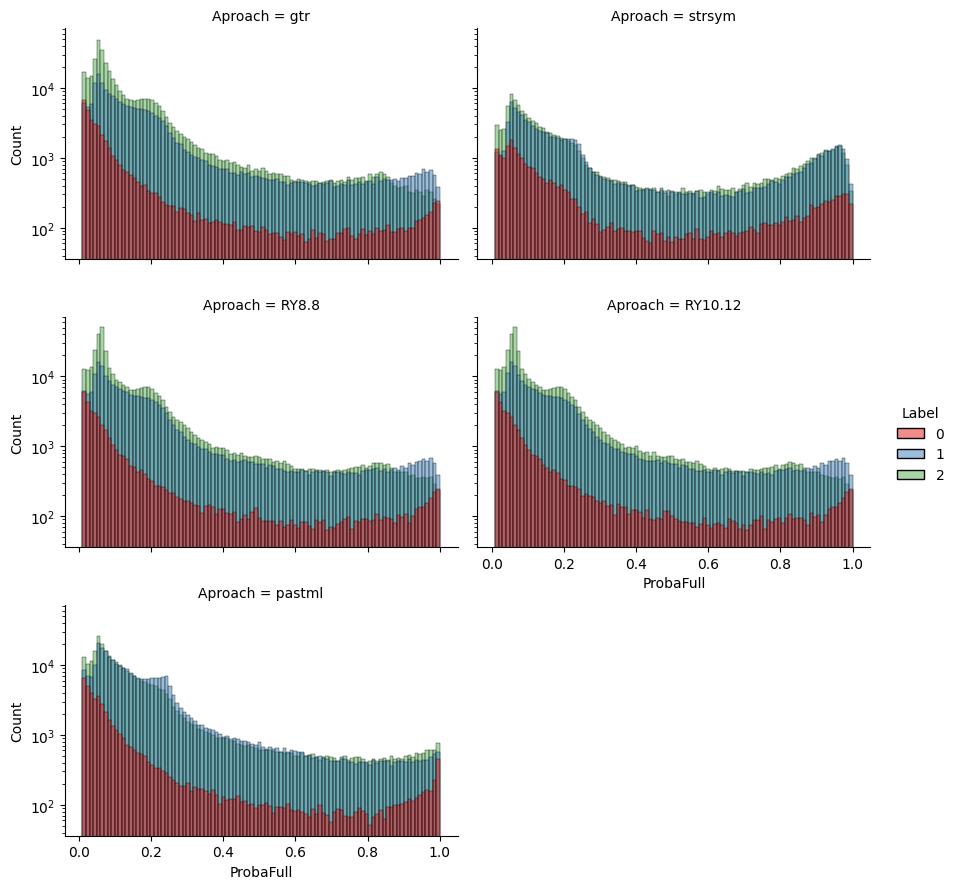

In [13]:
sns.displot(
    data=mut_nd1[(mut_nd1.Label >= 0) & (~mut_nd1.Aproach.str.contains("simple")) & (mut_nd1.ProbaFull > 0.01)], 
    x="ProbaFull", hue="Label", col="Aproach", col_wrap=2,
    log_scale=[False, True], bins=100, palette="Set1", aspect=1.5, height=3,
)
plt.show()

**Number of mutations in tree edges**

In [18]:
sns.kdeplot?

Signature:
sns.kdeplot(
    x=None,
    *,
    y=None,
    shade=None,
    vertical=False,
    kernel=None,
    bw=None,
    gridsize=200,
    cut=3,
    clip=None,
    legend=True,
    cumulative=False,
    shade_lowest=None,
    cbar=False,
    cbar_ax=None,
    cbar_kws=None,
    ax=None,
    weights=None,
    hue=None,
    palette=None,
    hue_order=None,
    hue_norm=None,
    multiple='layer',
    common_norm=True,
    common_grid=False,
    levels=10,
    thresh=0.05,
    bw_method='scott',
    bw_adjust=1,
    log_scale=None,
    color=None,
    fill=None,
    data=None,
    data2=None,
    warn_singular=True,
    **kwargs,
)
Docstring:
Plot univariate or bivariate distributions using kernel density estimation.

A kernel density estimate (KDE) plot is a method for visualizing the
distribution of observations in a dataset, analagous to a histogram. KDE
represents the data using a continuous probability density curve in one or
more dimensions.

The approach is explained further 

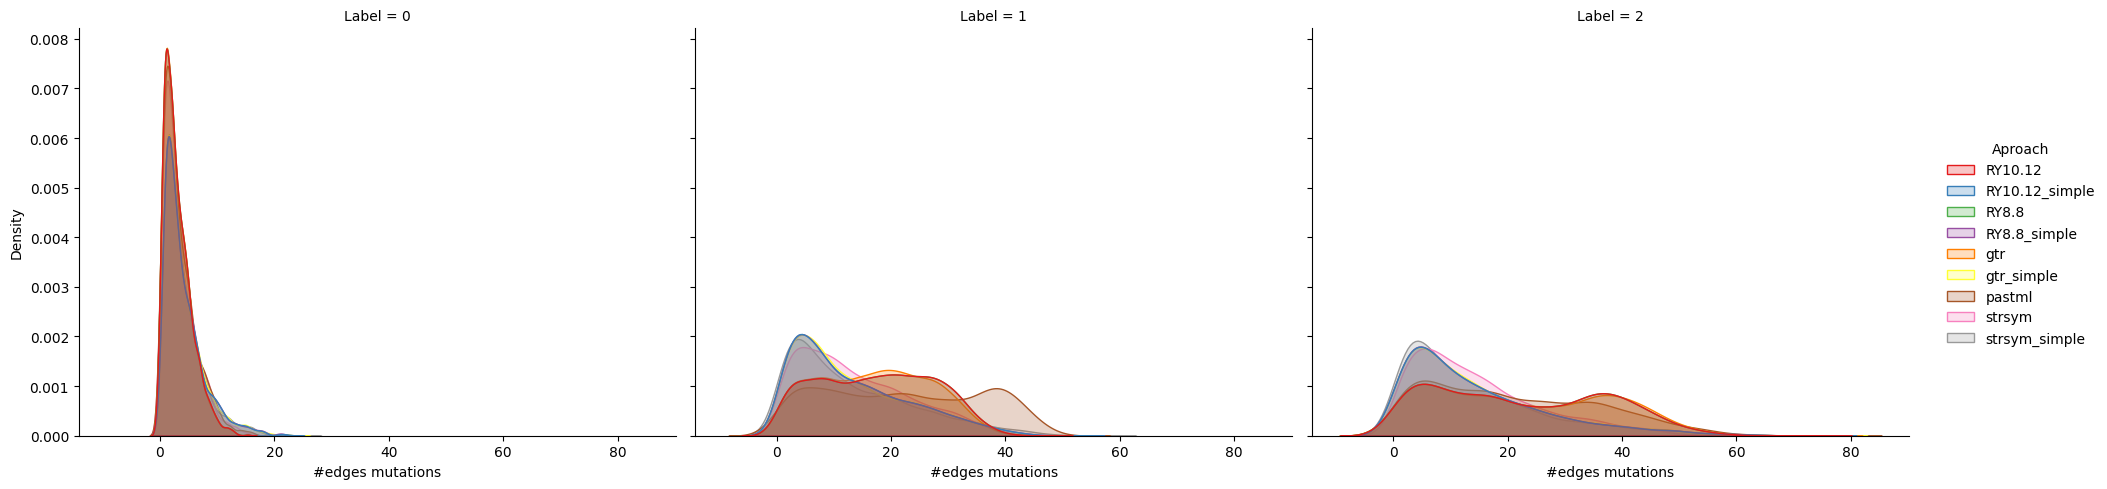

In [21]:
sns.displot(
    data=mut_nd1[mut_nd1.Label >= 0].groupby(["Aproach", "Label", "AltNode"]).ProbaFull.sum().reset_index(), 
    x="ProbaFull", col="Label", hue="Aproach", aspect=1.3, palette="Set1", kind="kde", fill=True,
).set_axis_labels("#edges mutations");
plt.show()

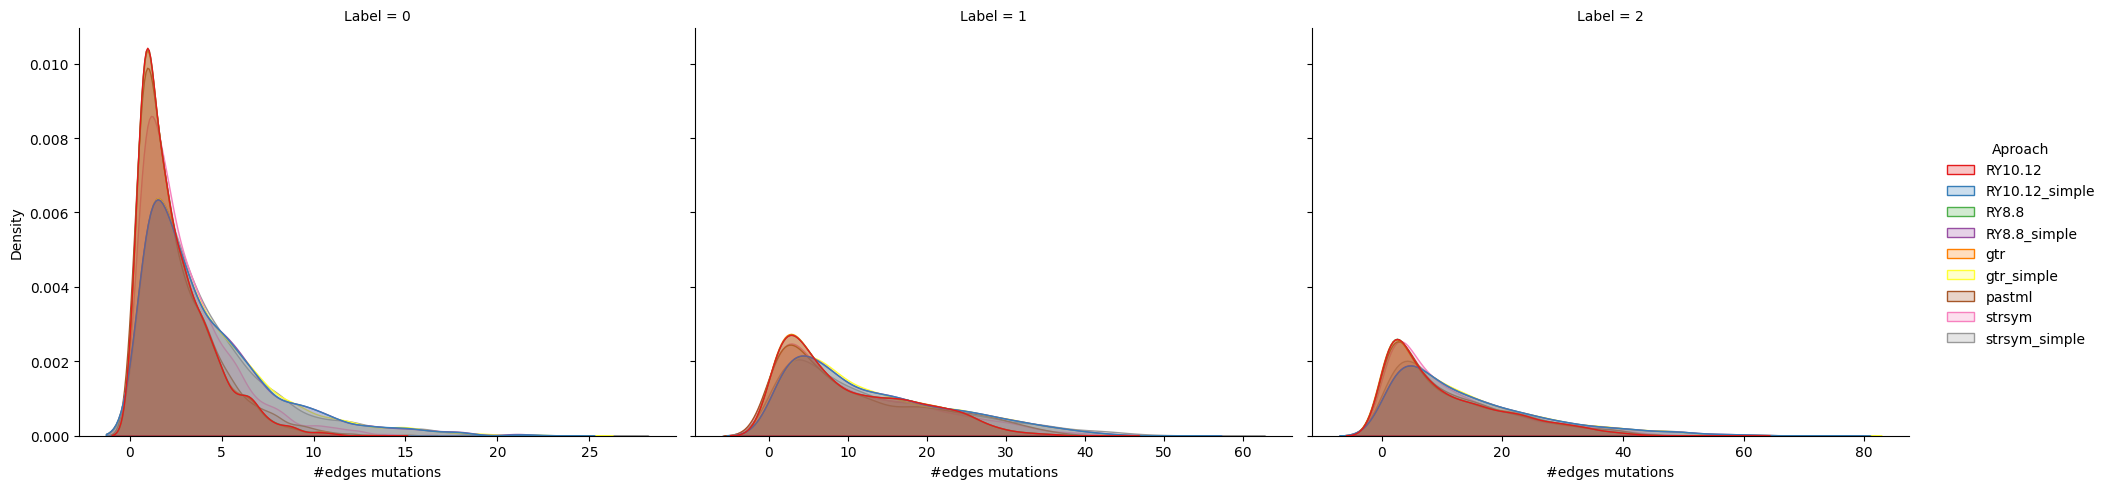

In [22]:
# after filtration (P > 0.3)
sns.displot(
    data=mut_nd1[(mut_nd1.Label >= 0) & (mut_nd1.ProbaFull > 0.3)].groupby(["Aproach", "Label", "AltNode"]).ProbaFull.sum().reset_index(), 
    x="ProbaFull", col="Label", hue="Aproach", aspect=1.3, palette="Set1", facet_kws=dict(sharex=False), kind="kde", fill=True,
).set_axis_labels("#edges mutations");
plt.show()

## Calculate freqs

In [7]:
def complete_sbs192_columns(df: pd.DataFrame):
    df = df.copy()
    if len(df.columns) != 192:
        for sbs192 in set(possible_sbs192).difference(df.columns.values):
            df[sbs192] = 0.
    df = df[possible_sbs192]
    return df


def jackknife_spectra_sampling(obs: pd.DataFrame, exp: pd.DataFrame, frac=0.5, n=1000):
    altnodes = obs.AltNode.unique()
    edges_sample_size = int(len(altnodes) * frac)
    obs_edges = obs.groupby(["AltNode", "RefNode", "Mut"]).ProbaFull.sum().unstack()
    obs_edges = complete_sbs192_columns(obs_edges)
    exp_nodes = exp.rename(columns={"Node": "RefNode"}).groupby(["RefNode", "Mut"]).Proba.sum().unstack()
    exp_nodes = complete_sbs192_columns(exp_nodes)

    spectra = []
    for _ in range(n):
        altnodes_sample = np.random.choice(altnodes, edges_sample_size, False)
        obs_sample = obs_edges.loc[altnodes_sample].reset_index(0, drop=True)
        exp_sample = exp_nodes.loc[obs_sample.index]
        
        obs_sample_cnt = obs_sample.sum()
        exp_sample_cnt = exp_sample.sum()

        assert (obs_sample_cnt.index == exp_sample_cnt.index).all()

        sample_spectra = obs_sample_cnt / exp_sample_cnt
        spectra.append(sample_spectra)

    return pd.DataFrame(spectra).fillna(0.)

### Choose low-rate category cutoff

In [21]:
lbl = "syn"
pcutoff = 0.3
obs_cytb_syn = mut_cytb[(mut_cytb.Label >= lbl2lbl_id(lbl)) & (mut_cytb.ProbaFull >= pcutoff)]
obs_nd1_syn  = mut_nd1[(mut_nd1.Label   >= lbl2lbl_id(lbl)) & (mut_nd1.ProbaFull  >= pcutoff)]
exp_cytb_syn = exp_cytb[(exp_cytb.Label == lbl) & (exp_cytb.Proba >= pcutoff)]
exp_nd1_syn  = exp_nd1[(exp_nd1.Label   == lbl) & (exp_nd1.Proba  >= pcutoff)]

obs_cytb_syn.loc[obs_cytb_syn.Cat < 3, "Cat"] = 3
obs_nd1_syn.loc[obs_nd1_syn.Cat < 3,   "Cat"] = 3
exp_cytb_syn.loc[exp_cytb_syn.Cat < 3, "Cat"] = 3
exp_nd1_syn.loc[exp_nd1_syn.Cat < 3,   "Cat"] = 3

In [45]:
data = []
for gene, mut, exp in zip(["cytb", "nd1"], [obs_cytb_syn, obs_nd1_syn], [exp_cytb_syn, exp_nd1_syn]):
    print(gene)

    for (appr, cat), obs_cur in mut.groupby(["Aproach", "Cat"]):
        if obs_cur.ProbaFull.sum() < 200 or obs_cur.Mut.nunique() < 20:
            print(appr, cat, "- pass")
            continue

        exp_cur = exp[(exp.Aproach == appr) & (exp.Cat == cat)]

        spectra = jackknife_spectra_sampling(obs_cur, exp_cur, n=100)
        spectra = spectra.assign(Gene=gene, Aproach=appr, Cat=cat).set_index(["Gene", "Aproach", "Cat"])
        data.append(spectra)

spectra_cats_to_compare = pd.concat(data)

cytb
RY10.12 3 - pass
RY10.12_simple 3 - pass
RY8.8 3 - pass
RY8.8_simple 3 - pass
gtr 3 - pass
gtr_simple 3 - pass
pastml 3 - pass
strsym 3 - pass
strsym_simple 3 - pass
nd1
RY10.12 3 - pass
RY10.12_simple 3 - pass
RY8.8 3 - pass
RY8.8_simple 3 - pass
gtr 3 - pass
gtr_simple 3 - pass
pastml 3 - pass
strsym 3 - pass
strsym_simple 3 - pass


<AxesSubplot:xlabel='Aproach-Cat', ylabel='Aproach-Cat'>

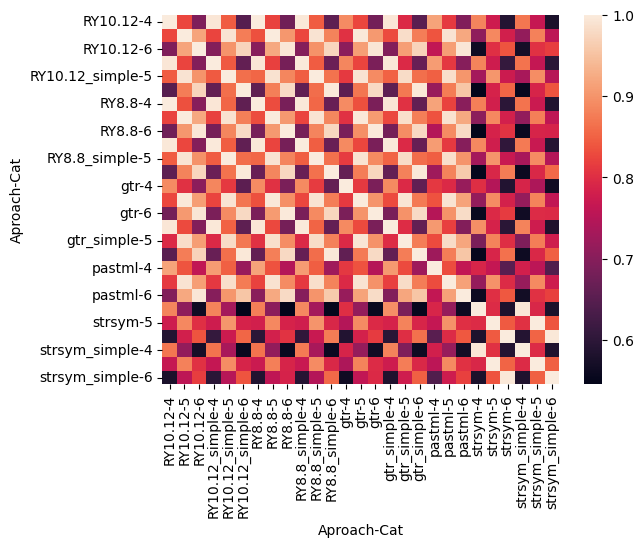

In [66]:
_sr = spectra_cats_to_compare.mean(level=[0,1,2])

sns.heatmap(pd.DataFrame(1 - squareform(pdist(_sr, "cosine")), index=_sr.index, columns=_sr.index).loc["cytb", "cytb"])

<AxesSubplot:xlabel='Aproach-Cat', ylabel='Aproach-Cat'>

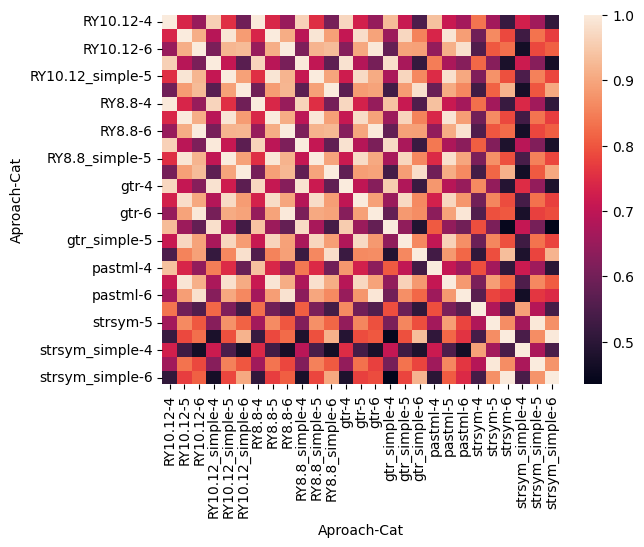

In [67]:
sns.heatmap(pd.DataFrame(1 - squareform(pdist(_sr, "cosine")), index=_sr.index, columns=_sr.index).loc["nd1", "nd1"])

In [23]:
exp_nd1.groupby(["Aproach", "Label", "Cat"]).Proba.sum().unstack().fillna(0).astype(int)

Cat                        1       2       3       4       5       6
Aproach        Label                                                
RY10.12        all    797274  307880  224396  289932  694217  577829
               syn      1674    1516    3070   47338  310621  521581
               syn4f     592       0       0    6849  150918  493464
               syn_c    3839    4549    9210  128317  630026  577815
RY10.12_simple all    840174  325026  237789  309147  733482  609861
               syn      1750    1580    3221   50515  327879  550748
               syn4f     624       0       0    7383  159669  521199
               syn_c    4002    4740    9663  136779  664299  609846
RY8.8          all    797266  307879  224394  289929  694213  577824
               syn      1674    1516    3070   47339  310619  521580
               syn4f     592       0       0    6850  150917  493464
               syn_c    3839    4549    9210  128318  630023  577811
RY8.8_simple   all    840183  325023  237786  309159  733473  609870
               syn      1750    1580    3221   50520  327873  550759
               syn4f     624       0       0    7386  159660  521214
               syn_c    4002    4740    9663  136788  664299  609849
gtr            all    797105  307804  224373  289744  694051  577647
               syn      1674    1516    3069   47355  310823  521801
               syn4f     591       0       0    6905  151262  493883
               syn_c    3839    4548    9207  128254  629945  577635
gtr_simple     all    839670  324720  237669  308937  733128  609066
               syn      1750    1580    3222   50473  327917  550263
               syn4f     624       0       0    7425  159879  520899
               syn_c    4002    4740    9666  136569  663993  608991
pastml         all    826735  319640  232889  299898  719708  598988
               syn      1748    1559    3159   48339  319873  537936
               syn4f     624       0       0    6792  154067  507418
               syn_c    3994    4679    9477  131432  651487  598973
strsym         all    803447  310314  226623  294551  700821  582754
               syn      1673    1518    3072   48234  315532  529667
               syn4f     588       0       0    7546  156060  503125
               syn_c    3843    4555    9216  129609  634476  582751
strsym_simple  all    840735  325179  237939  309324  733692  610674
               syn      1754    1578    3210   50650  330006  555024
               syn4f     627       0       0    7932  163188  527202
               syn_c    4008    4734    9630  136086  663642  610668

In [7]:
LOW_CAT = 4

In [25]:
freqs_nd1_high_rate = exp_nd1[exp_nd1.Cat > LOW_CAT].groupby(["Aproach", "Node", "Label", "Mut"]).Proba.sum().unstack().fillna(0.)
freqs_nd1_low_rate = exp_nd1[exp_nd1.Cat <= LOW_CAT].groupby(["Aproach", "Node", "Label", "Mut"]).Proba.sum().unstack().fillna(0.)

freqs_cytb_high_rate = exp_cytb[exp_cytb.Cat > LOW_CAT].groupby(["Aproach", "Node", "Label", "Mut"]).Proba.sum().unstack().fillna(0.)
freqs_cytb_low_rate = exp_cytb[exp_cytb.Cat <= LOW_CAT].groupby(["Aproach", "Node", "Label", "Mut"]).Proba.sum().unstack().fillna(0.)

assert freqs_nd1_high_rate.shape[1] == 192
assert freqs_nd1_low_rate.shape[1] == 192
assert freqs_cytb_high_rate.shape[1] == 192
assert freqs_cytb_low_rate.shape[1] == 192

freqs_nd1_high_rate = freqs_nd1_high_rate.reset_index()
freqs_nd1_low_rate = freqs_nd1_low_rate.reset_index()
freqs_cytb_high_rate = freqs_cytb_high_rate.reset_index()
freqs_cytb_low_rate = freqs_cytb_low_rate.reset_index()

## Categorizing mutations

In [26]:
mut_cytb[mut_cytb.Label >= 0].groupby(["Aproach", "Label", "Cat"]).ProbaFull.sum().unstack().fillna(0).astype(int)

Cat                     1     2     3      4      5      6
Aproach        Label                                      
RY10.12        0      546  1523  2667   2333   1659    387
               1       10    36   564   7010  44884   5373
               2        0     0     0    311  17745  46478
RY10.12_simple 0      636  1832  3036   2568   1809    404
               1       11    36   606   6573  31201   2982
               2        0     0     1    279  13760  27252
RY8.8          0      546  1523  2665   2331   1658    386
               1       10    35   564   7003  44860   5374
               2        0     0     0    311  17734  46514
RY8.8_simple   0      638  1836  3036   2569   1817    410
               1       11    37   606   6569  31204   2986
               2        0     0     1    282  13751  27280
gtr            0      547  1518  2628   2383   1694    369
               1       10    32   562   6920  43617   5270
               2        0     0     0    322  18834  46901
gtr_simple     0      644  1832  3010   2623   1853    394
               1       11    37   602   6527  30820   2991
               2        0     0     1    280  14118  27148
pastml         0      693  1795  2970   2476   1757    454
               1       14    35   738  10765  56569   4907
               2        0     0     1    361  20119  42069
strsym         0      609  1756  3041   2412   1746    359
               1       12    34   593   6693  32441   3079
               2        0     0     0    280  14463  29066
strsym_simple  0      661  1838  3037   2377   1778    372
               1       14    35   605   6545  30050   2699
               2        0     0     1    280  13567  26676

In [27]:
mut_nd1[mut_nd1.Label >= 0].groupby(["Aproach", "Label", "Cat"]).ProbaFull.sum().unstack().fillna(0).astype(int)

Cat                     1     2     3     4      5      6
Aproach        Label                                     
RY10.12        0      338   936  2000  1909   1583    476
               1        1    43   125  3266  33421   7501
               2        0     0     0   117   8138  48596
RY10.12_simple 0      405  1148  2341  2218   1738    510
               1        1    41   128  3252  24705   4236
               2        0     0     0   112   6101  29515
RY8.8          0      338   935  2001  1909   1583    476
               1        1    43   125  3265  33419   7502
               2        0     0     0   117   8136  48597
RY8.8_simple   0      404  1148  2341  2221   1737    508
               1        1    41   128  3255  24704   4234
               2        0     0     0   112   6099  29507
gtr            0      338   930  1992  1935   1610    458
               1        1    41   125  3246  32626   7309
               2        0     0     0   118   8360  48859
gtr_simple     0      409  1129  2346  2246   1719    498
               1        1    41   131  3230  24446   4183
               2        0     0     0   111   6125  29349
pastml         0      429  1167  2112  2089   1745    529
               1        1    45   152  4531  44218   7261
               2        0     0     0   138   9168  44366
strsym         0      389  1094  2254  2095   1673    431
               1        1    41   129  3144  27425   4323
               2        0     0     0   109   6242  31022
strsym_simple  0      426  1167  2253  2107   1689    459
               1        3    41   131  3180  24384   3854
               2        0     0     0   114   5919  28563

In [8]:
def calc_tree_mutspec2(mut:pd.DataFrame, freqs, lbl="syn", pmin=0.0, pmax=1.0, collapse=False):
    mut = mut[
        (mut.Label >= lbl2lbl_id(lbl)) & 
        (mut.ProbaFull.between(pmin, pmax, "right"))
    ]
    # print("#mutations:", mut.ProbaFull.sum())
    if mut.ProbaFull.sum() < 100:
        return None
    mut = mut.groupby(["RefNode", "AltNode", "Mut"]).ProbaFull.sum().unstack()
    assert len(mut) > 0

    for sbs192 in set(possible_sbs192).difference(mut.columns):
        mut[sbs192] = 0.0
            
    mut = mut[possible_sbs192]
    freqs = freqs[freqs.Label == lbl]
    edges_df = mut.index.to_frame(False)

    freqs = edges_df.merge(freqs, left_on="RefNode", right_on="Node")\
        .set_index(["RefNode", "AltNode"])[possible_sbs192]
    
    assert (mut.columns == freqs.columns).all()
    assert (mut.index == freqs.index).all()

    spectra = (mut / freqs).fillna(0.)
    spectra = (spectra.T / spectra.T.sum(axis=0)).T

    return spectra


In [9]:
# space = [0.00, 0.05, 0.30, .50, 0.80, 1.00]
space = [0.00, 0.30, 1.00]

### SYN (phylo-like adjusting)

In [32]:
lbl = "syn"

ms_cat_cytb = []
ms_cat_nd1 = []

for apr in mut_cytb.Aproach.unique():
    if "simple" in apr:
        continue
    mapr_cytb = mut_cytb[(mut_cytb.Aproach == apr)]
    mapr_nd1  = mut_nd1[(mut_nd1.Aproach == apr)]

    for p1, p2 in zip(space[:-1], space[1:]):
        # CYTB
        m = mapr_cytb[(mapr_cytb.Cat <= LOW_CAT)]
        # print(f"{apr}, {p1}-{p2}, cytb low - {m[m.Label >= lbl2lbl_id(lbl)].ProbaFull.sum():.2f}")
        ms_low_rate = calc_tree_mutspec2(
            m, 
            freqs_cytb_low_rate[freqs_cytb_low_rate.Aproach == apr], 
            lbl, p1, p2)
        if ms_low_rate is not None:
            ms_low_rate["Cat"] = f"{p1:.2f}_{p2:.2f}"
            ms_low_rate["Aproach"] = apr
            ms_low_rate["Rate"] = "low"
            ms_cat_cytb.append(ms_low_rate)

        m = mapr_cytb[(mapr_cytb.Cat > LOW_CAT)]
        # print(f"{apr}, {p1}-{p2}, cytb high - {m[m.Label >= lbl2lbl_id(lbl)].ProbaFull.sum():.2f}")
        ms_high_rate = calc_tree_mutspec2(
            m, 
            freqs_cytb_high_rate[freqs_cytb_high_rate.Aproach == apr], 
            lbl, p1, p2)
        if ms_high_rate is not None:
            ms_high_rate["Cat"] = f"{p1:.2f}_{p2:.2f}"
            ms_high_rate["Aproach"] = apr
            ms_high_rate["Rate"] = "high"
            ms_cat_cytb.append(ms_high_rate)

        # ND1
        m = mapr_nd1[(mapr_nd1.Cat <= LOW_CAT)]
        # print(f"{apr}, {p1}-{p2}, nd1 low - {m[m.Label >= lbl2lbl_id(lbl)].ProbaFull.sum():.2f}")
        ms_low_rate = calc_tree_mutspec2(
            m, 
            freqs_nd1_low_rate[freqs_nd1_low_rate.Aproach == apr], 
            lbl, p1, p2)
        if ms_low_rate is not None:
            ms_low_rate["Cat"] = f"{p1:.2f}_{p2:.2f}"
            ms_low_rate["Aproach"] = apr
            ms_low_rate["Rate"] = "low"
            ms_cat_nd1.append(ms_low_rate)

        m = mapr_nd1[(mapr_nd1.Cat > LOW_CAT)]
        # print(f"{apr}, {p1}-{p2}, nd1 high - {m[m.Label >= lbl2lbl_id(lbl)].ProbaFull.sum():.2f}")
        ms_high_rate = calc_tree_mutspec2(
            m, 
            freqs_nd1_high_rate[freqs_nd1_high_rate.Aproach == apr], 
            lbl, p1, p2)
        if ms_high_rate is not None:
            ms_high_rate["Cat"] = f"{p1:.2f}_{p2:.2f}"
            ms_high_rate["Aproach"] = apr
            ms_high_rate["Rate"] = "high"
            ms_cat_nd1.append(ms_high_rate)
    
    # break

ms_cat_cytb_df = pd.concat(ms_cat_cytb)
ms_cat_nd1_df = pd.concat(ms_cat_nd1)

In [10]:
exp_cytb

,Pos,Mut,Label,Node,Aproach,Proba,Cat
0,3,T[G>A]A,syn,Node208,gtr_simple,1.0,1
1,3,T[G>A]A,syn_c,Node208,gtr_simple,1.0,1
2,3,T[G>C]A,syn_c,Node208,gtr_simple,1.0,1
4,3,T[G>T]A,syn_c,Node208,gtr_simple,1.0,1
5,3,T[G>A]A,all,Node208,gtr_simple,1.0,1
...,...,...,...,...,...,...,...
87192513,1138,A[A>G]G,all,Node559,pastml,1.0,3
87192514,1138,A[A>T]G,all,Node559,pastml,1.0,3
87192515,1139,A[G>A]A,all,Node559,pastml,1.0,2
87192516,1139,A[G>C]A,all,Node559,pastml,1.0,2


In [110]:
lbl = "syn"

for gene, mut, exp in zip(["cytb", "nd1"], [mut_cytb, mut_nd1], [exp_cytb, exp_nd1]):
    for appr in mut.Aproach.unique():
        obs_appr = mut[mut.Aproach == appr]
        exp_appr = exp[exp.Aproach == appr]

        obs_appr_high_rate = 
        spectra_appr = jackknife_spectra_sampling(obs_appr, exp_appr)


In [ ]:
exp_cytb[(exp_cytb.Label.str.fullmatch("syn"))]

In [103]:
x = half_jackknife_spectra(
    mut_cytb[(mut_cytb.Aproach == "pastml") & (mut_cytb.Cat > 4) & (mut_cytb.Label > 0)], 
    exp_cytb[(exp_cytb.Aproach == "pastml") & (exp_cytb.Label == "syn")]
)

In [105]:
x

Mut,A[A>C]A,A[A>C]C,A[A>C]G,A[A>C]T,C[A>C]A,C[A>C]C,C[A>C]G,C[A>C]T,G[A>C]A,G[A>C]C,...,C[T>G]G,C[T>G]T,G[T>G]A,G[T>G]C,G[T>G]G,G[T>G]T,T[T>G]A,T[T>G]C,T[T>G]G,T[T>G]T
0,NaN,NaN,NaN,NaN,0.021181,0.026368,0.016912,0.022581,0.022024,0.030436,...,0.003563,0.001195,0.004665,0.007430,0.022094,0.009845,0.003019,0.004210,0.003772,0.003459
1,NaN,NaN,NaN,NaN,0.021681,0.027273,0.017005,0.023086,0.022482,0.029878,...,0.003223,0.001223,0.005863,0.007145,0.016706,0.008237,0.003182,0.004792,0.004272,0.004406
2,NaN,NaN,NaN,NaN,0.021569,0.025449,0.017698,0.024525,0.021451,0.034332,...,0.003144,0.001592,0.006531,0.007990,0.020045,0.008408,0.004059,0.005057,0.003702,0.003688
3,NaN,NaN,NaN,NaN,0.021521,0.026600,0.017569,0.025207,0.019904,0.029832,...,0.002163,0.001439,0.006270,0.009175,0.022486,0.008357,0.003106,0.003855,0.003796,0.005069
4,NaN,NaN,NaN,NaN,0.021274,0.027353,0.017090,0.023706,0.019521,0.032616,...,0.002637,0.000966,0.005376,0.007624,0.021758,0.008401,0.003297,0.004113,0.004173,0.003468
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,NaN,NaN,NaN,NaN,0.020830,0.025368,0.016632,0.024528,0.019415,0.029574,...,0.002901,0.002057,0.005998,0.007657,0.020942,0.009366,0.003119,0.004341,0.002891,0.003037
96,NaN,NaN,NaN,NaN,0.020963,0.025788,0.016448,0.024094,0.017445,0.032550,...,0.003354,0.001254,0.006830,0.005172,0.021195,0.008092,0.003305,0.003841,0.003964,0.003421
97,NaN,NaN,NaN,NaN,0.020453,0.027228,0.017072,0.024544,0.022332,0.029683,...,0.003006,0.001179,0.003374,0.008982,0.020484,0.007949,0.003216,0.004265,0.004183,0.002711
98,NaN,NaN,NaN,NaN,0.019761,0.026269,0.015634,0.024832,0.020528,0.030801,...,0.003087,0.001293,0.005498,0.004527,0.019324,0.009496,0.003147,0.004130,0.004560,0.004497


In [93]:
x[1]

Mut,A[A>C]A,A[A>C]C,A[A>C]G,A[A>C]T,C[A>C]A,C[A>C]C,C[A>C]G,C[A>C]T,G[A>C]A,G[A>C]C,...,C[T>G]G,C[T>G]T,G[T>G]A,G[T>G]C,G[T>G]G,G[T>G]T,T[T>G]A,T[T>G]C,T[T>G]G,T[T>G]T
RefNode,,,,,,,,,,,,,,,,,,,,,
Node915,0.0,0.0,0.0,0.0,9.998500,9.999360,14.810766,8.804000,4.994003,1.996601,...,1.064222,1.979000,2.000000,NaN,0.998500,NaN,3.968000,3.256726,3.999000,2.997000
Node397,0.0,0.0,0.0,0.0,9.289302,8.896473,13.767948,7.958611,2.972112,3.705812,...,1.316205,11.371440,0.947326,0.853252,1.090300,1.499730,3.778986,3.110633,3.882859,3.652988
Node389,0.0,0.0,0.0,0.0,13.516153,6.760986,19.526676,19.434076,2.704923,2.791206,...,1.103733,2.044633,0.134332,1.101394,0.362274,1.157987,1.903379,3.891902,NaN,1.396357
Node83,0.0,0.0,0.0,0.0,11.360703,2.764243,17.685690,17.876688,3.342023,1.895503,...,0.805983,1.846427,1.284143,0.912715,0.174278,1.559700,2.455698,3.778133,1.947918,1.274397
Node2,0.0,0.0,0.0,0.0,7.110514,8.248694,13.025601,11.501204,0.877206,1.436269,...,3.515914,4.084485,0.861839,1.284974,1.382578,0.985414,3.495889,4.354965,1.301526,2.038403
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Node73,0.0,0.0,0.0,0.0,14.796613,9.642388,18.397203,20.458815,6.039691,1.990958,...,1.900046,0.458873,NaN,0.771618,NaN,0.187400,0.696639,3.009686,0.364991,2.766996
Node276,0.0,0.0,0.0,0.0,14.889513,5.940117,14.387037,9.755410,1.606018,2.485538,...,5.242841,9.953004,0.091300,0.211868,0.998500,1.394296,3.229809,2.373031,0.177872,3.077684
Node550,0.0,0.0,0.0,0.0,15.925501,8.819153,18.869656,19.678873,2.979426,4.698493,...,0.867700,0.997000,0.059540,NaN,0.055544,0.155300,3.976832,2.502458,1.952112,NaN


In [77]:
x[1].loc[x[0].loc[['Node1', 'Node10', 'Node100', 'Node1000']].index.get_level_values(-1)]

Mut,A[A>C]A,A[A>C]C,A[A>C]G,A[A>C]T,C[A>C]A,C[A>C]C,C[A>C]G,C[A>C]T,G[A>C]A,G[A>C]C,...,C[T>G]G,C[T>G]T,G[T>G]A,G[T>G]C,G[T>G]G,G[T>G]T,T[T>G]A,T[T>G]C,T[T>G]G,T[T>G]T
RefNode,,,,,,,,,,,,,,,,,,,,,
Node2,0.0,0.0,0.0,0.0,7.110514,8.248694,13.025601,11.501204,0.877206,1.436269,...,3.515914,4.084485,0.861839,1.284974,1.382578,0.985414,3.495889,4.354965,1.301526,2.038403
Node11,0.0,0.0,0.0,0.0,10.344019,4.682885,18.380636,16.943840,3.270110,2.521302,...,1.543791,2.263990,0.158352,1.317679,0.297727,1.083983,1.065790,5.583419,0.063500,0.963119
Node99,0.0,0.0,0.0,0.0,10.210315,3.703542,17.255234,18.509888,3.761528,1.998030,...,1.036059,2.453413,0.633604,1.152990,1.477918,1.591450,2.735057,5.400482,1.903935,1.119626
Node999,0.0,0.0,0.0,0.0,9.041490,7.978337,14.338375,15.451381,3.566584,1.654844,...,1.549264,2.859621,0.227240,0.531407,0.608400,1.751600,2.039437,3.205454,0.971120,1.577565


In [46]:
b = a.groupby(["AltNode", "RefNode", "Mut"]).ProbaFull.sum().unstack()

In [47]:
b.loc[["Node1", "Node10"]]

,Mut,A[A>G]A,A[A>G]C,A[A>G]G,A[A>G]T,A[C>T]A,A[C>T]C,A[C>T]G,A[C>T]T,A[G>A]A,A[G>A]C,...,T[T>A]G,T[T>A]T,T[T>C]A,T[T>C]C,T[T>C]G,T[T>C]T,T[T>G]A,T[T>G]C,T[T>G]G,T[T>G]T
AltNode,RefNode,,,,,,,,,,,,,,,,,,,,,
Node1,Node2,NaN,0.492401,NaN,0.400056,3.637527,2.412165,1.590060,1.987988,NaN,0.513601,...,0.099634,0.336973,3.995193,4.080080,1.277063,2.793623,0.014411,0.17462,NaN,NaN
Node10,Node11,0.119432,0.422900,0.084536,0.276230,4.018863,1.492859,1.827796,2.124876,0.110354,0.417394,...,0.053404,0.031945,4.916330,7.317266,1.951793,2.672977,NaN,0.00660,0.005544,0.008951


In [45]:
a = mut_cytb[(mut_cytb.Aproach == "pastml") & (mut_cytb.Cat > 4) & (mut_cytb.Label > 0)]
a.head()

,Mut,Label,PosInGene,RefNode,AltNode,Aproach,ProbaMut,ProbaFull,MutBase,Cat
4586,T[C>T]A,1,33,Node208,Node207,pastml,0.174797,0.174797,C>T,5
4587,T[T>C]A,1,33,Node208,Node207,pastml,0.164217,0.164217,T>C,5
4588,T[C>T]A,1,33,Node207,Node254,pastml,0.392959,0.392959,C>T,5
4589,T[T>C]A,1,33,Node207,Node254,pastml,0.072518,0.072518,T>C,5
4590,T[C>T]A,1,33,Node207,Node206,pastml,0.227706,0.227706,C>T,5


#### Write to files

In [13]:
ms_cat_cytb_df_long = ms_cat_cytb_df.reset_index().melt(["Aproach", "RefNode", "AltNode", "Cat", "Rate"], possible_sbs192, value_name="MutSpec")
ms_cat_nd1_df_long  = ms_cat_nd1_df.reset_index().melt( ["Aproach", "RefNode", "AltNode", "Cat", "Rate"], possible_sbs192, value_name="MutSpec")

# write images
for apr in ms_cat_cytb_df_long.Aproach.unique():
    if "simple" in apr:
        continue
    print(apr)
    for rt in ms_cat_cytb_df_long.Rate.unique():
        if rt == "low":
            continue
        plt.figure(figsize=(50, 10))
        sns.barplot(
            x="Mut", y="MutSpec", hue="Cat", data=ms_cat_cytb_df_long[(ms_cat_cytb_df_long.Aproach == apr) & (ms_cat_cytb_df_long.Rate == rt)], 
            errwidth=1, order=ordered_sbs192_kp, palette="Blues",
        )
        plt.title(f"{apr} {lbl} {rt} rate")
        plt.xticks(rotation=90)
        plt.savefig(f"../figures/approaches/ex{LOW_CAT}/mammals_cytb_{apr}_{lbl}_{rt}_rate_reduced_cats.svg", bbox_inches="tight")
        plt.savefig(f"../figures/approaches/ex{LOW_CAT}/mammals_cytb_{apr}_{lbl}_{rt}_rate_reduced_cats.pdf", bbox_inches="tight")
        plt.close()

        plt.figure(figsize=(50, 10))
        sns.barplot(
            x="Mut", y="MutSpec", hue="Cat", data=ms_cat_nd1_df_long[(ms_cat_nd1_df_long.Aproach == apr) & (ms_cat_nd1_df_long.Rate == rt)], 
            errwidth=1, order=ordered_sbs192_kp, palette="Blues",
        )
        plt.title(f"{apr} {lbl} {rt} rate")
        plt.xticks(rotation=90)
        plt.savefig(f"../figures/approaches/ex{LOW_CAT}/mammals_nd1_{apr}_{lbl}_{rt}_rate_reduced_cats.svg", bbox_inches="tight")
        plt.savefig(f"../figures/approaches/ex{LOW_CAT}/mammals_nd1_{apr}_{lbl}_{rt}_rate_reduced_cats.pdf", bbox_inches="tight")
        plt.close()

RY10.12


### SYN (COSMIC-like adjusting)

In [11]:
lbl = "syn_c"

ms_cat_cytb = []
for apr in mut_cytb.Aproach.unique():
    if "simple" in apr:
        continue
    for p1, p2 in zip(space[:-1], space[1:]):
        ms = calc_tree_mutspec2(
            mut_cytb[mut_cytb.Aproach == apr], 
            freqs_cytb[freqs_cytb.Aproach == apr], 
            lbl, p1, p2)
        ms["Cat"] = f"{p1:.2f}_{p2:.2f}"
        ms["Aproach"] = apr
        ms_cat_cytb.append(ms)

ms_cat_cytb_df = pd.concat(ms_cat_cytb)
ms_cat_cytb_df = ms_cat_cytb_df.reset_index().melt(["Aproach", "RefNode", "AltNode", "Cat"], possible_sbs192, value_name="MutSpec")

ms_cat_nd1 = []
for apr in mut_nd1.Aproach.unique():
    if "simple" in apr:
        continue
    for p1, p2 in zip(space[:-1], space[1:]):
        ms = calc_tree_mutspec2(
            mut_nd1[mut_nd1.Aproach == apr], 
            freqs_nd1[freqs_nd1.Aproach == apr], 
            lbl, p1, p2)
        ms["Cat"] = f"{p1:.2f}_{p2:.2f}"
        ms["Aproach"] = apr
        ms_cat_nd1.append(ms)

ms_cat_nd1_df = pd.concat(ms_cat_nd1)
ms_cat_nd1_df = ms_cat_nd1_df.reset_index().melt(["Aproach", "RefNode", "AltNode", "Cat"], possible_sbs192, value_name="MutSpec")

In [12]:
for apr in ms_cat_cytb_df.Aproach.unique():
    plt.figure(figsize=(50, 10))
    sns.barplot(
        x="Mut", y="MutSpec", hue="Cat", data=ms_cat_cytb_df[ms_cat_cytb_df.Aproach == apr], 
        errwidth=1, order=ordered_sbs192_kp, palette="Blues",
    )
    plt.title(f"{apr} {lbl}")
    plt.xticks(rotation=90)
    plt.savefig(f"../figures/approaches/mammals_cytb_{apr}_{lbl}_reduced_cats.svg", bbox_inches="tight")
    plt.savefig(f"../figures/approaches/mammals_cytb_{apr}_{lbl}_reduced_cats.pdf", bbox_inches="tight")
    plt.close()


for apr in ms_cat_nd1_df.Aproach.unique():
    plt.figure(figsize=(50, 10))
    sns.barplot(
        x="Mut", y="MutSpec", hue="Cat", data=ms_cat_nd1_df[ms_cat_nd1_df.Aproach == apr], errwidth=1, order=ordered_sbs192_kp, palette="Blues",
    )
    plt.title(f"{apr} {lbl}")
    plt.xticks(rotation=90)
    plt.savefig(f"../figures/approaches/mammals_nd1_{apr}_{lbl}_reduced_cats.svg", bbox_inches="tight")
    plt.savefig(f"../figures/approaches/mammals_nd1_{apr}_{lbl}_reduced_cats.pdf", bbox_inches="tight")
    plt.close()

## Compare different cats

In [28]:
def get_cossim(a: pd.DataFrame, b: pd.DataFrame):
    assert (a.columns == b.columns).all()
    assert (a.index == b.index).all()
    dotprod = (a * b).sum(axis=1)
    a_norm = (a ** 2).sum(axis=1) ** 0.5
    b_norm = (b ** 2).sum(axis=1) ** 0.5
    cossim = dotprod / (a_norm * b_norm)
    return cossim

### Spectrum for each edge and then averaging

In [299]:
lbl = "syn"
space = np.linspace(0, 1, 11)
print(lbl, space)

ms_cat = []
for apr in mut_cytb.Aproach.unique():
    if "simple" in apr:
        continue
    for p1, p2 in zip(space[:-1], space[1:]):
        ms = calc_tree_mutspec2(
            mut_cytb[mut_cytb.Aproach == apr], 
            freqs_cytb[freqs_cytb.Aproach == apr], 
            lbl, p1, p2)
        ms["Cat"] = f"{p1:.2f}_{p2:.2f}"
        ms["Aproach"] = apr
        ms["Gene"] = "CYTB"
        ms_cat.append(ms)

for apr in mut_nd1.Aproach.unique():
    if "simple" in apr:
        continue
    for p1, p2 in zip(space[:-1], space[1:]):
        ms = calc_tree_mutspec2(
            mut_nd1[mut_nd1.Aproach == apr], 
            freqs_nd1[freqs_nd1.Aproach == apr], 
            lbl, p1, p2)
        ms["Cat"] = f"{p1:.2f}_{p2:.2f}"
        ms["Aproach"] = apr
        ms["Gene"] = "ND1"
        ms_cat.append(ms)

ms_cat_df = pd.concat(ms_cat).set_index(["Gene", "Aproach", "Cat"], append=True)

ava_spectras = ms_cat_df.mean(level=[2, 3, 4])

syn [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


### Calculate similarities

In [305]:
sim_df_mean_raw = pd.DataFrame(spatial.distance.squareform(1 - spatial.distance.pdist(ava_spectras, "cosine")), index=ava_spectras.index, columns=ava_spectras.index)

In [306]:
print(sim_df_mean_raw.index.levels)

[['CYTB', 'ND1'], ['pastml_v2', 'proba_v2', 'strsym_proba', 'unrest_proba'], ['0.00_0.10', '0.10_0.20', '0.20_0.30', '0.30_0.40', '0.40_0.50', '0.50_0.60', '0.60_0.70', '0.70_0.80', '0.80_0.90', '0.90_1.00']]


In [307]:
data = []
for g in sim_df_mean_raw.index.levels[0]:
    for appr in sim_df_mean_raw.index.levels[1]:
        a = sim_df_mean_raw.loc[(g, appr), (g, appr)]
        a.index.rename("Cat1", inplace=True)
        a.columns.rename("Cat2", inplace=True)
        a = a.stack().rename("Sim").reset_index()
        a["Gene"] = g
        a["Approach"] = appr
        data.append(a)

sim_df_mean = pd.concat(data)
sim_df_mean.head()

,Cat1,Cat2,Sim,Gene,Approach
0,0.00_0.10,0.00_0.10,0.000000,CYTB,pastml_v2
1,0.00_0.10,0.10_0.20,0.787333,CYTB,pastml_v2
2,0.00_0.10,0.20_0.30,0.642856,CYTB,pastml_v2
3,0.00_0.10,0.30_0.40,0.532163,CYTB,pastml_v2
4,0.00_0.10,0.40_0.50,0.434031,CYTB,pastml_v2


In [308]:
## TOO MANY ZEROS
# data = []
# for cat1 in ms_cat_df.Cat.unique():
#     a = ms_cat_df[ms_cat_df.Cat == cat1].drop("Cat", axis=1)
#     a = a[(a != 0).sum(axis=1) >= 16]
#     for cat2 in ms_cat_df.Cat.unique():
#         if cat1 != cat2:
#             b = ms_cat_df[ms_cat_df.Cat == cat2].drop("Cat", axis=1)
#             idx = a.index.intersection(b.index)
#             sim = get_cossim(a.loc[idx], b.loc[idx]).rename("Sim").reset_index()
#             sim["Cat1"] = cat1
#             sim["Cat2"] = cat2
#             data.append(sim)

# sim_df = pd.concat(data)
# sim_df_mean = sim_df.groupby(["Gene", "Aproach", "Cat1", "Cat2"]).Sim.mean().reset_index()
# sim_df_mean.head()

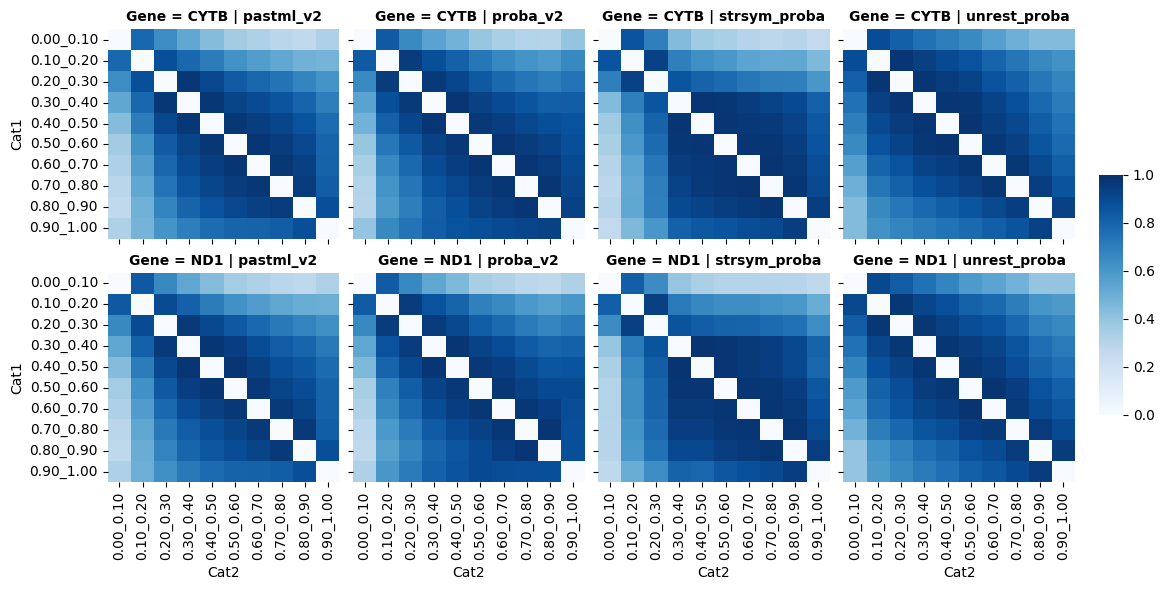

In [309]:
def facet_heatmap(data, color, **kws):
    data = data.pivot(index="Cat1", columns='Cat2', values='Sim')
    sns.heatmap(data, cmap='Blues', **kws)  # <-- Pass kwargs to heatmap

with sns.plotting_context(font_scale=5.5):
    g = sns.FacetGrid(sim_df_mean, row="Gene", col="Approach", size=3, aspect=1)

cbar_ax = g.fig.add_axes([.92, .3, .02, .4])  # <-- Create a colorbar axes

g = g.map_dataframe(facet_heatmap,
                    cbar_ax=cbar_ax,
                    vmin=0, vmax=1, )  # <-- Specify the colorbar axes and limits

g.set_titles(col_template="{col_name}", fontweight='bold', size=10)
g.fig.subplots_adjust(right=.9)  # <-- Add space so the colorbar doesn't overlap the plot
plt.show()

### Merged spectrum for full tree
Bad method

In [327]:
def assign_cat(p: float, interval=0.1):
    left = p // interval / 10
    right = left + interval
    return f"{left:.1f}_{right:.1f}"

In [328]:
mut_nd1["Cat"] = mut_nd1.ProbaFull.apply(assign_cat)
mut_cytb["Cat"] = mut_nd1.ProbaFull.apply(assign_cat)

In [326]:
freqs_mean = pd.concat([
    freqs_nd1[(freqs_nd1.Label == lbl) & (~freqs_nd1.Aproach.str.contains("simple"))].drop("Label", axis=1)\
              .assign(Gene="ND1").set_index(["Gene", "Aproach", "Node"]).mean(level=[0,1]),
    freqs_cytb[(freqs_cytb.Label == lbl) & (~freqs_cytb.Aproach.str.contains("simple"))].drop("Label", axis=1)\
               .assign(Gene="CYTB").set_index(["Gene", "Aproach", "Node"]).mean(level=[0,1]),
])[possible_sbs192]
freqs_mean

A[A>C]A  A[A>C]C  A[A>C]G  A[A>C]T    C[A>C]A    C[A>C]C  \
Gene Aproach                                                                  
ND1  strsym_proba      0.0      0.0      0.0      0.0  13.280685  10.119089   
     unrest_proba      0.0      0.0      0.0      0.0  11.527154   8.490058   
     proba_v2          0.0      0.0      0.0      0.0  12.719027   9.485722   
     pastml_v2         0.0      0.0      0.0      0.0  13.533498   9.752068   
CYTB strsym_proba      0.0      0.0      0.0      0.0  11.210285   6.858742   
     unrest_proba      0.0      0.0      0.0      0.0   9.922981   5.907197   
     proba_v2          0.0      0.0      0.0      0.0  10.863875   6.481020   
     pastml_v2         0.0      0.0      0.0      0.0  11.541223   6.874748   

                     C[A>C]G    C[A>C]T   G[A>C]A   G[A>C]C  ...   C[T>G]G  \
Gene Aproach                                                 ...             
ND1  strsym_proba   9.429810  10.230880  1.670049  1.997323  ...  1.446725   
     unrest_proba   8.821317   9.384316  1.517787  1.685508  ...  1.952499   
     proba_v2       9.452098  10.438284  1.569669  1.949811  ...  2.258378   
     pastml_v2      9.524027  11.175736  1.681468  1.887395  ...  2.282641   
CYTB strsym_proba  14.945701  13.770204  3.134061  3.373130  ...  1.752265   
     unrest_proba  13.651434  12.399337  2.717384  2.877056  ...  2.400105   
     proba_v2      14.638159  13.500678  2.963953  3.233310  ...  2.653754   
     pastml_v2     14.986118  14.199733  3.080081  3.166723  ...  2.707250   

                    C[T>G]T   G[T>G]A   G[T>G]C   G[T>G]G   G[T>G]T   T[T>G]A  \
Gene Aproach                                                                    
ND1  strsym_proba  1.508318  0.198409  0.288594  0.210158  0.270928  1.470090   
     unrest_proba  2.020472  0.257976  0.420276  0.248933  0.389531  1.963185   
     proba_v2      2.481739  0.315526  0.619990  0.284345  0.552110  2.217662   
     pastml_v2     2.607771  0.327029  0.621658  0.305552  0.560988  2.226176   
CYTB strsym_proba  1.660712  0.322019  0.263601  0.592229  0.452321  1.971328   
     unrest_proba  2.433802  0.470729  0.421121  0.728345  0.652592  2.831979   
     proba_v2      2.942959  0.570050  0.673063  0.817318  0.973605  3.148485   
     pastml_v2     3.070719  0.584662  0.667607  0.838789  0.917376  3.128412   

                    T[T>G]C   T[T>G]G   T[T>G]T  
Gene Aproach                                     
ND1  strsym_proba  1.329108  0.951039  0.943379  
     unrest_proba  1.794892  1.277997  1.225744  
     proba_v2      2.210254  1.359756  1.480085  
     pastml_v2     2.087561  1.290527  1.501248  
CYTB strsym_proba  2.003533  0.953465  0.785592  
     unrest_proba  3.062536  1.412646  1.147987  
     proba_v2      3.705543  1.549101  1.402232  
     pastml_v2     3.621609  1.404500  1.414438  

[8 rows x 192 columns]

In [332]:
nmuts_tree = pd.concat([
    mut_nd1[(mut_nd1.Label >= 1) & (mut_nd1.RefNode != "ROOT") & (~mut_nd1.Aproach.str.contains("simple"))]\
        .assign(Gene="ND1").groupby(["Gene", "Aproach", "Cat", "Mut"]).ProbaFull.sum().unstack().fillna(0.),
    mut_cytb[(mut_cytb.Label >= 1) & (mut_cytb.RefNode != "ROOT") & (~mut_cytb.Aproach.str.contains("simple"))]\
        .assign(Gene="CYTB").groupby(["Gene", "Aproach", "Cat", "Mut"]).ProbaFull.sum().unstack().fillna(0.)
])
for sbs in set(possible_sbs192).difference(nmuts_tree.columns):
    nmuts_tree[sbs] = 0.
nmuts_tree = nmuts_tree[possible_sbs192]

In [336]:
freqs_mean["Cat"] = freqs_mean["A[A>C]A"].apply(lambda x: nmuts_tree.index.levels[2].values)
freqs_mean = freqs_mean.explode("Cat").set_index("Cat", append=True)

In [338]:
idx = nmuts_tree.index.intersection(freqs_mean.index)
nmuts_tree = nmuts_tree.loc[idx]
freqs_mean = freqs_mean.loc[idx]

assert (freqs_mean.columns == nmuts_tree.columns).all()
assert (freqs_mean.index == nmuts_tree.index).all()

ava_spectras = (nmuts_tree / freqs_mean).fillna(0.)
ava_spectras = (ava_spectras.T / ava_spectras.T.sum(axis=0)).T

### Calculate similarities

In [339]:
sim_df_mean_raw = pd.DataFrame(spatial.distance.squareform(1 - spatial.distance.pdist(ava_spectras, "cosine")), index=ava_spectras.index, columns=ava_spectras.index)

In [340]:
print(sim_df_mean_raw.index.levels)

[['CYTB', 'ND1'], ['pastml_v2', 'proba_v2', 'strsym_proba', 'unrest_proba'], ['0.0_0.1', '0.1_0.2', '0.2_0.3', '0.3_0.4', '0.4_0.5', '0.5_0.6', '0.6_0.7', '0.7_0.8', '0.8_0.9', '0.9_1.0']]


In [341]:
data = []
for g in sim_df_mean_raw.index.levels[0]:
    for appr in sim_df_mean_raw.index.levels[1]:
        a = sim_df_mean_raw.loc[(g, appr), (g, appr)]
        a.index.rename("Cat1", inplace=True)
        a.columns.rename("Cat2", inplace=True)
        a = a.stack().rename("Sim").reset_index()
        a["Gene"] = g
        a["Approach"] = appr
        data.append(a)

sim_df_mean = pd.concat(data)
sim_df_mean.head()

,Cat1,Cat2,Sim,Gene,Approach
0,0.0_0.1,0.0_0.1,0.000000,CYTB,pastml_v2
1,0.0_0.1,0.1_0.2,0.997718,CYTB,pastml_v2
2,0.0_0.1,0.2_0.3,0.997208,CYTB,pastml_v2
3,0.0_0.1,0.3_0.4,0.990547,CYTB,pastml_v2
4,0.0_0.1,0.4_0.5,0.978879,CYTB,pastml_v2


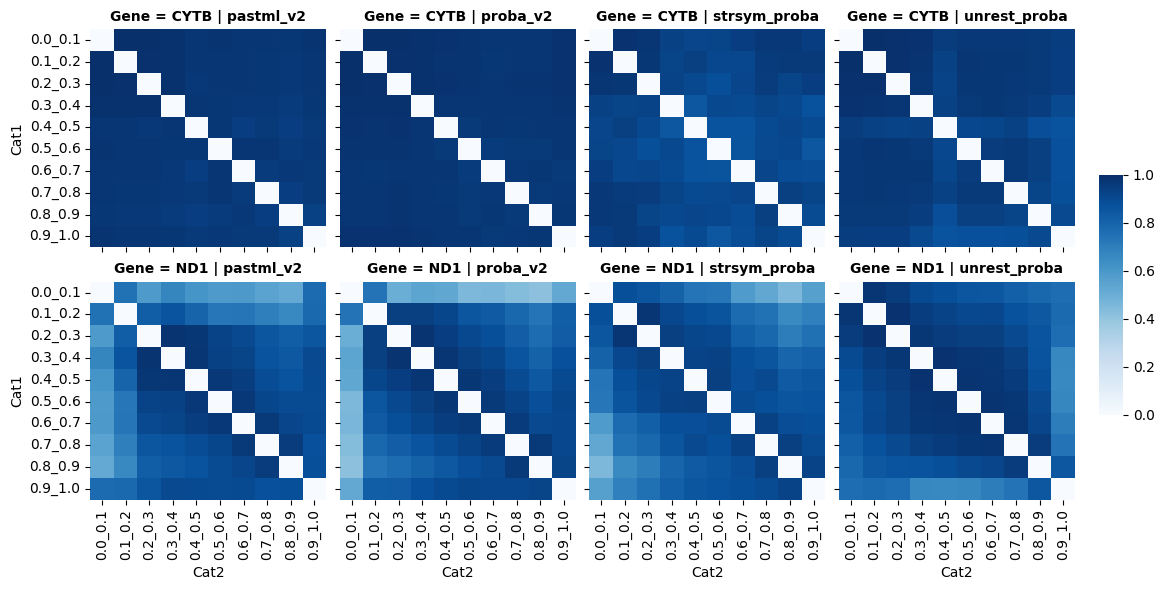

In [342]:
def facet_heatmap(data, color, **kws):
    data = data.pivot(index="Cat1", columns='Cat2', values='Sim')
    sns.heatmap(data, cmap='Blues', **kws)  # <-- Pass kwargs to heatmap

with sns.plotting_context(font_scale=5.5):
    g = sns.FacetGrid(sim_df_mean, row="Gene", col="Approach", size=3, aspect=1)

cbar_ax = g.fig.add_axes([.92, .3, .02, .4])  # <-- Create a colorbar axes

g = g.map_dataframe(facet_heatmap,
                    cbar_ax=cbar_ax,
                    vmin=0, vmax=1, )  # <-- Specify the colorbar axes and limits

g.set_titles(col_template="{col_name}", fontweight='bold', size=10)
g.fig.subplots_adjust(right=.9)  # <-- Add space so the colorbar doesn't overlap the plot
plt.show()